In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [42]:
np.random.seed(347)
class SupplyChain:
  def __init__(self, BS):
    self.BS = BS
    np.random.seed(47)
    self.state = np.zeros([BS,2]) # tuple, (time, inventory)
    self.time = 0

    self.holdingCost = 0.5
    self.bakcOrderCost = 1.0

    self.means = [10,20] # mean of the demand
    self.sigma = [1,2] # standard deviation for demand

  def reset(self):
    self.state = np.zeros([BS, 2]) # tuple, (time, inventory)
    self.time = 0

  def step(self, action):
    if self.time > 2:
      return None
    self.state[:,0]+=1
    # inventory_{t+1} = max\{0, inventory_{t} + action - demand }

    demand = np.random.randn(BS)*self.sigma[self.time]+self.means[self.time]
    # print(demand)
    self.state[:,1]+=action-demand
    cost = np.maximum(self.state[:,1],0)*self.holdingCost # holding cost
    cost += (np.maximum(-self.state[:,1],0)*self.bakcOrderCost)
    reward = - cost
    # print (cost)
    self.state[:,1] = np.maximum(self.state[:,1],0)
    self.time += 1
    return self.state+0, reward, self.time <2

BS = 4
game = SupplyChain(BS)
game.reset()
game.state
game.step(np.array([10,30,5,10]))
game.step(np.array([20,30,5,21]))
game.state

array([[ 2.        ,  2.95748344],
       [ 2.        , 25.09857221],
       [ 2.        ,  0.        ],
       [ 2.        ,  0.        ]])

In [43]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.Activation = F.leaky_relu
    self.affine1 = nn.Linear(2, 8)
    self.affine2 = nn.Linear(8, 2) # mu, sigma

  def forward(self, x):
    x = self.Activation(self.affine1(x))
    x = (self.affine2(x))
    mu = x[:,0]
    sigma = torch.exp(x[:,1])

    return mu, sigma

game.reset()

torch.manual_seed(347)
actor = Actor()
mu, sigma = actor(torch.Tensor(game.state))
mu, sigma

(tensor([0.0311, 0.0311, 0.0311, 0.0311], grad_fn=<SelectBackward>),
 tensor([1.3751, 1.3751, 1.3751, 1.3751], grad_fn=<ExpBackward>))

In [44]:
def rollout(actor, game, state):
  game.reset()
  notDone = True
  log_probs = []
  rewards = []
  while notDone:
    mu, sigma = actor(torch.Tensor(game.state))
    action = np.random.randn(BS)*sigma.data.numpy()+ mu.data.numpy()

    log_prob = -torch.log(0.0001 + sigma*np.math.sqrt(2*3.1415) ) - 1/2 *(torch.tensor(action)-mu)**2 / (sigma**2)
    log_probs.append(log_prob)

    s, r, notDone = game.step(action)
    rewards.append(r)

  return log_probs, rewards, state

log_probs, rewards = rollout(actor, game)
log_probs, rewards


([tensor([-1.2809, -1.4130, -2.2087, -1.8471], dtype=torch.float64,
         grad_fn=<SubBackward0>),
  tensor([-1.3056, -1.0505, -1.9215, -1.0480], dtype=torch.float64,
         grad_fn=<SubBackward0>)],
 [array([ -9.44173875,  -9.84046651, -12.32206746,  -9.24545292]),
  array([-15.29202094, -20.33456478, -22.23461889, -20.05718429])])

-1.807890493177058

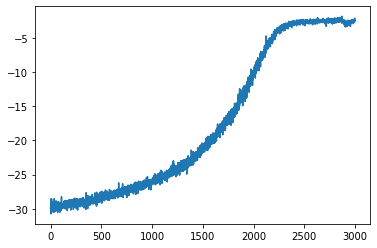

In [52]:
BS = 50
game = SupplyChain(BS)

torch.manual_seed(347)   
actor = Actor()
actor_optim = optim.Adam(actor.parameters(), lr=1e-3)

rewardHistory = []
for it in range(3000):
  log_probs, rewards = rollout(actor, game)
  R = np.sum(np.array(rewards),0)
  rewardHistory.append(np.mean(R))
  logProbSum = torch.sum(torch.stack(log_probs),0)
  actor_loss = -torch.mean(logProbSum*(torch.tensor(R)))

  actor_optim.zero_grad()
  actor_loss.backward()
  actor_optim.step()
plt.plot(rewardHistory)
np.max(rewardHistory)


In [53]:
game.reset()
mu, sigma = actor(torch.Tensor(game.state))

game.step(mu.data.numpy())
print (game.state[0])
mu, sigma = actor(torch.Tensor(game.state))
print (mu[0], sigma[0])

[1.         3.24002395]
tensor(20.4777, grad_fn=<SelectBackward>) tensor(0.0655, grad_fn=<SelectBackward>)
